In [1]:
import numpy as np
import pandas as pd
import os, json 
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.autograd import Variable

In [2]:
# Load in dataset
df = pd.read_pickle('./problemsV7.pkl')
label = df['grade'].values
df = df.drop('grade',axis=1).values

# Split train and test data
train_dataset, test_dataset, train_label, test_label = train_test_split(df, label, test_size=.3, stratify=label)

In [3]:
# Convert dataset to tensor
class Dataset(data.Dataset):
    def __init__(self, df, label, smote=False, conv=False):
        self.dataset = df
        self.label = label
        if smote: self.__smote__() 
        
    def __getitem__(self, index):
            return torch.Tensor(self.dataset[index].astype(float)), self.label[index]
    def __len__(self):
        return self.dataset.shape[0]
    
    def __smote__(self):
        sm = SMOTE(random_state=27)
        self.dataset, self.label = sm.fit_sample(self.dataset, self.label)

In [4]:
# Network definition
class LinNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, num_classes)
        
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x
    
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv1d(1, 6, 5)
        self.pool = nn.MaxPool1d(2, 2)
        self.conv2 = nn.Conv1d(6, 16, 5)
        self.fc1 = nn.Linear(1536, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 13)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [5]:
# Get device info
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# Variables
input_size = df.shape[1]
classes = np.unique(label)
num_classes = len(classes)
learning_rate = .001
batch_size = 16
num_epochs = 5

In [7]:
# Convert from DF to tensor
train_set = Dataset(train_dataset, train_label, smote=True)
trainloader = data.DataLoader(dataset = train_set, batch_size = batch_size, shuffle = True)

test_set = Dataset(test_dataset, test_label, smote=False)
testloader = data.DataLoader(dataset = test_set, batch_size = batch_size, shuffle = True)

In [8]:
# Initilalize network

# Conv = True for Conv : False for linear
conv = True

# model = NN(input_size=input_size, num_classes=num_classes).to(device)
model = ConvNet().to(device)

In [9]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [10]:
# Train network
for epoch in range(num_epochs):
    for i, (route, labels) in enumerate(trainloader):
        route = Variable(route)
        labels = Variable(labels)
 
        optimizer.zero_grad()
    
        if conv: route = route.unsqueeze(1)
        outputs = model(route)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        if (i+1) % 500 == 0:
            print ('Epoch [%d/%d], Iter [%d] Loss: %.4f' %(epoch+1, num_epochs, i+1, loss.data))

Epoch [1/5], Iter [500] Loss: 2.2281
Epoch [1/5], Iter [1000] Loss: 1.9464
Epoch [1/5], Iter [1500] Loss: 1.7087
Epoch [2/5], Iter [500] Loss: 2.0008
Epoch [2/5], Iter [1000] Loss: 1.7309
Epoch [2/5], Iter [1500] Loss: 1.6185
Epoch [3/5], Iter [500] Loss: 1.2960
Epoch [3/5], Iter [1000] Loss: 1.6591
Epoch [3/5], Iter [1500] Loss: 1.7329
Epoch [4/5], Iter [500] Loss: 1.7596
Epoch [4/5], Iter [1000] Loss: 1.8401
Epoch [4/5], Iter [1500] Loss: 1.0253
Epoch [5/5], Iter [500] Loss: 1.3298
Epoch [5/5], Iter [1000] Loss: 1.2812
Epoch [5/5], Iter [1500] Loss: 1.2379


Accuracy of the network: 35.44593270173146 %
              precision    recall  f1-score   support

         0.0       0.54      0.82      0.65       933
         1.0       0.19      0.08      0.12       178
         2.0       0.25      0.19      0.22       428
         3.0       0.19      0.39      0.26       352
         4.0       0.21      0.16      0.18       133
         5.0       0.15      0.10      0.12       319
         6.0       0.00      0.00      0.00        11
         7.0       0.18      0.07      0.10       422
         8.0       0.00      0.00      0.00         9
         9.0       0.00      0.00      0.00       187
        10.0       0.10      0.06      0.07        53
        11.0       0.12      0.04      0.06        24
        12.0       0.00      0.00      0.00        12

    accuracy                           0.35      3061
   macro avg       0.15      0.15      0.14      3061
weighted avg       0.28      0.35      0.30      3061

    Difference  Counts
0          

<BarContainer object of 13 artists>

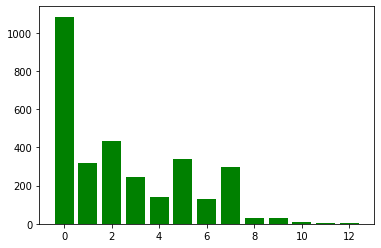

In [12]:
# Test Network
correct = total = 0
pred = t_label = np.array([])
with torch.no_grad():
    for data in testloader:
        route, labels = data
        if conv: route = route.unsqueeze(1)
        outputs = model(route)
        _, predicted = torch.max(outputs.data, 1)
        pred = np.append(predicted.numpy(), pred)
        t_label = np.append(labels.numpy(), t_label)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network: {accuracy} %'.format(accuracy=100 * correct / total))

print(classification_report(t_label, pred))

difference = abs(pred - t_label)
data = np.array(np.unique(difference, return_counts=True))
print(pd.DataFrame({'Difference': data[0], 'Counts': data[1]}))

# Successes within X grades
g_range = 1
trials = sum(data[1])
rel_successes = sum([ elem for cnt, elem in enumerate(data[1]) if cnt <= g_range])
print('Success within {g_range} grades: {percent}%'.format(percent=(rel_successes/trials) * 100, g_range=g_range))

plt.bar(data[0], data[1], color='green')

In [96]:
# Save model
# MODEL_PATH = 'NN_model.pth'
# torch.save(net, MODEL_PATH)

# net = torch.load(MODEL_PATH)